In [ ]:
!pip install pydicom SimpleITK matplotlib --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.1 MB/s eta 0:00:00


Slice shape: (128, 128)


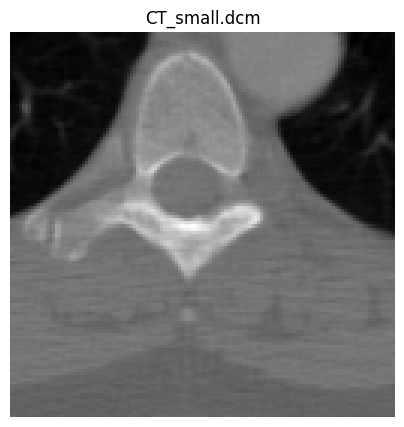

In [ ]:
from pydicom.data import get_testdata_file
import pydicom, matplotlib.pyplot as plt

# Load the built-in test CT (always valid)
path = get_testdata_file("CT_small.dcm")
ds   = pydicom.dcmread(path)
img  = ds.pixel_array  # a single 2D slice

print("Slice shape:", img.shape)
plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
plt.title("CT_small.dcm")
plt.axis("off")
plt.show()


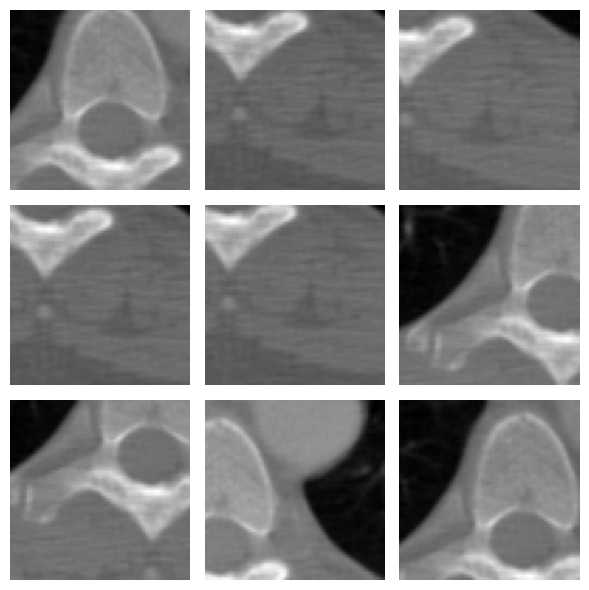

In [ ]:
import numpy as np, os

patch_size = 64
n_patches  = 50
out_dir    = "patches"
os.makedirs(out_dir, exist_ok=True)

h, w = img.shape
for i in range(n_patches):
    y = np.random.randint(0, h - patch_size)
    x = np.random.randint(0, w - patch_size)
    patch = img[y:y+patch_size, x:x+patch_size]
    plt.imsave(f"{out_dir}/patch_{i:03d}.png", patch, cmap="gray")

# Display 9 example patches
fig, axes = plt.subplots(3,3, figsize=(6,6))
for ax, idx in zip(axes.flatten(), range(9)):
    ax.imshow(plt.imread(f"{out_dir}/patch_{idx:03d}.png"), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# 1) Imports and setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import os

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2) Hyperparameters
batch_size   = 64
image_size   = 64
nz           = 100    # latent vector size
ngf          = 64     # generator feature maps
ndf          = 64     # discriminator feature maps
num_epochs   = 20
lr           = 0.0002
beta1        = 0.5    # Adam beta1

# 3) Create dataset + dataloader
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # scale to [-1,1]
])

dataset = datasets.ImageFolder(
    root=".",
    transform=transform
)
# Make sure your patches directory is named 'patches' and has an __init__.py:
#   patches/
#     __init__.py
#     patch_000.png, patch_001.png, ...
#
# Or symlink it: `!ln -s patches ./patches` in Colab.

dataloader = torch.utils.data.DataLoader(
    datasets.ImageFolder("patches", transform=transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# 4) Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 5) Generator network
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input Z -> (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # state: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # state: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, ngf,   4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, 1,      4, 2, 1, bias=False),
            nn.Tanh()
            # output: 1 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# 6) Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input: 1 x 64 x 64
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state: (ndf*2) x 16 x 16
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state: (ndf*4) x 8 x 8
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state: (ndf*8) x 4 x 4
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # output: scalar probability
        )

    def forward(self, input):
        return self.main(input).view(-1)

# 7) Instantiate models & apply init
netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)

# 8) Loss and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# 9) Training loop
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

os.makedirs("results", exist_ok=True)

for epoch in range(1, num_epochs+1):
    for i, (real_images, _) in enumerate(dataloader, 1):
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size_i = real_images.size(0)
        labels_real = torch.full((batch_size_i,), 1., device=device)
        output = netD(real_images)
        lossD_real = criterion(output, labels_real)
        lossD_real.backward()

        noise = torch.randn(batch_size_i, nz, 1, 1, device=device)
        fake_images = netG(noise)
        labels_fake = torch.full((batch_size_i,), 0., device=device)
        output = netD(fake_images.detach())
        lossD_fake = criterion(output, labels_fake)
        lossD_fake.backward()
        optimizerD.step()

        netG.zero_grad()
        labels_gen = torch.full((batch_size_i,), 1., device=device)
        output = netD(fake_images)
        lossG = criterion(output, labels_gen)
        lossG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Step [{i}/{len(dataloader)}] "
                  f"Loss_D: {lossD_real+lossD_fake:.4f} Loss_G: {lossG:.4f}")

    # save sample generated images each epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    grid = make_grid(fake, padding=2, normalize=True)
    save_image(grid, f"results/fake_samples_epoch_{epoch:02d}.png")

# 10) Save final models
torch.save(netG.state_dict(), "models/generator.pth")
torch.save(netD.state_dict(), "models/discriminator.pth")
print("Training complete! Models saved in ./models and samples in ./results")


Using device: cpu


FileNotFoundError: Found no valid file for the classes .config, sample_data. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [ ]:
# Create a folder called "nodule" inside "patches"
mkdir -p patches/nodule

# Move every .png into that folder
mv patches/*.png patches/nodule/


SyntaxError: invalid syntax (<ipython-input-5-d50f1cca988d>, line 2)

In [ ]:
!mkdir -p patches/nodule
!mv patches/*.png patches/nodule/
!ls patches/nodule


patch_000.png  patch_010.png  patch_020.png  patch_030.png  patch_040.png
patch_001.png  patch_011.png  patch_021.png  patch_031.png  patch_041.png
patch_002.png  patch_012.png  patch_022.png  patch_032.png  patch_042.png
patch_003.png  patch_013.png  patch_023.png  patch_033.png  patch_043.png
patch_004.png  patch_014.png  patch_024.png  patch_034.png  patch_044.png
patch_005.png  patch_015.png  patch_025.png  patch_035.png  patch_045.png
patch_006.png  patch_016.png  patch_026.png  patch_036.png  patch_046.png
patch_007.png  patch_017.png  patch_027.png  patch_037.png  patch_047.png
patch_008.png  patch_018.png  patch_028.png  patch_038.png  patch_048.png
patch_009.png  patch_019.png  patch_029.png  patch_039.png  patch_049.png


In [ ]:
dataset = datasets.ImageFolder(root="patches", transform=transform)


In [ ]:
from torch.utils.data import DataLoader

# Use the same transform you defined earlier
dataset = datasets.ImageFolder(root="patches", transform=transform)

# Create a DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=16,    # start small so it’s quick to load
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"Found {len(dataset)} images in {dataset.classes[0]} class.")


Found 50 images in nodule class.


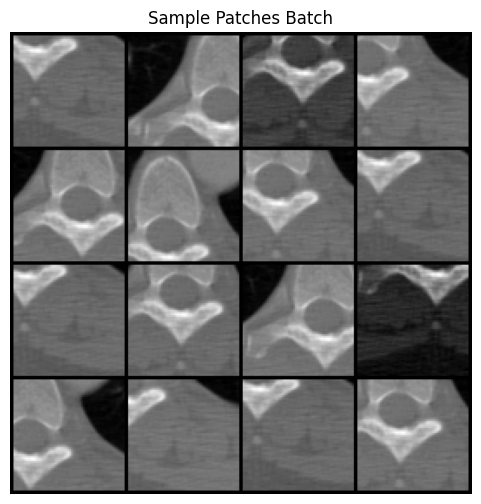

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Grab one batch
images, _ = next(iter(dataloader))   # ignore labels (_)

# Make a grid of the first 16 patches
grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)

# Plot it
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.title("Sample Patches Batch")
plt.show()


In [ ]:
# === DCGAN Training ===

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
import os

# 1) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)

# 2) Hyperparameters
nz         = 100     # noise vector size
ngf        = 64      # generator feature maps
ndf        = 64      # discriminator feature maps
num_epochs = 10      # you can increase later
lr         = 0.0002
beta1      = 0.5
batch_size = 64      # should match your dataloader

# 3) Weight init
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

# 4) Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # input: Z (nz x 1 x1)
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8), nn.ReLU(True),
            # state: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),
            # state: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            # state: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf*2, ngf,   4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),   nn.ReLU(True),
            # state: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, 1,      4, 2, 1, bias=False),
            nn.Tanh()  # output: 1 x 64 x 64 in [-1,1]
        )

    def forward(self, x):
        return self.net(x)

# 5) Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # input: 1 x 64 x 64
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1,     4, 1, 0, bias=False),
            nn.Sigmoid()  # scalar output
        )

    def forward(self, x):
        return self.net(x).view(-1)

# 6) Instantiate and init
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)

# 7) Loss & Optimizers
criterion  = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# 8) Fixed noise for monitoring
fixed_noise = torch.randn(16, nz, 1, 1, device=device)

# 9) Prepare output folder
os.makedirs("results", exist_ok=True)

# 10) Training loop
for epoch in range(1, num_epochs+1):
    for i, (real_imgs, _) in enumerate(dataloader, 1):
        real_imgs = real_imgs.to(device)
        b_size    = real_imgs.size(0)
        # Train Discriminator on real
        netD.zero_grad()
        labels_real = torch.full((b_size,), 1., device=device)
        out_real    = netD(real_imgs)
        lossD_real  = criterion(out_real, labels_real)
        # Train Discriminator on fake
        noise       = torch.randn(b_size, nz, 1, 1, device=device)
        fake_imgs   = netG(noise)
        labels_fake = torch.full((b_size,), 0., device=device)
        out_fake    = netD(fake_imgs.detach())
        lossD_fake  = criterion(out_fake, labels_fake)
        lossD       = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        # Train Generator
        netG.zero_grad()
        labels_gen = torch.full((b_size,), 1., device=device)
        out_gen    = netD(fake_imgs)
        lossG      = criterion(out_gen, labels_gen)
        lossG.backward()
        optimizerG.step()

    # Save and display progress
    print(f"Epoch {epoch}/{num_epochs}  Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")
    with torch.no_grad():
        sample = netG(fixed_noise).detach().cpu()
    grid = make_grid(sample, nrow=4, normalize=True)
    save_image(grid, f"results/epoch{epoch:02d}.png")

print("✅ Training complete! Check the `results/` folder for generated images.")


Training on: cpu
Epoch 1/10  Loss_D: 0.1433  Loss_G: 9.9637
Epoch 2/10  Loss_D: 0.0902  Loss_G: 10.8257
Epoch 3/10  Loss_D: 0.0356  Loss_G: 7.7252
Epoch 4/10  Loss_D: 0.1485  Loss_G: 7.3681
Epoch 5/10  Loss_D: 0.0064  Loss_G: 8.4316
Epoch 6/10  Loss_D: 0.0354  Loss_G: 10.2815
Epoch 7/10  Loss_D: 0.0024  Loss_G: 13.9091
Epoch 8/10  Loss_D: 0.0477  Loss_G: 12.2797
Epoch 9/10  Loss_D: 0.0122  Loss_G: 11.4637
Epoch 10/10  Loss_D: 0.5028  Loss_G: 23.6283
✅ Training complete! Check the `results/` folder for generated images.


In [ ]:
git clone https://github.com/Pksn1994/ct-lung-synthesis.git
cd ct-lung-synthesis


SyntaxError: invalid syntax (<ipython-input-11-1ef20101d5ce>, line 1)

In [ ]:
# Clone the repo
!git clone https://github.com/Pksn1994/ct-lung-synthesis.git

# Change into that directory
%cd ct-lung-synthesis

# Copy files (example)
!cp /content/Untitled1.ipynb ./train_gan.ipynb
!cp -r /content/patches ./patches
!cp -r /content/results ./results
!mkdir -p models
!cp /content/models/* ./models

# Commit & push
!git add .
!git commit -m "Initial commit: notebook, data, results, models"
!git push -u origin main


Cloning into 'ct-lung-synthesis'...
/content/ct-lung-synthesis
cp: cannot stat '/content/Untitled1.ipynb': No such file or directory
cp: cannot stat '/content/models/*': No such file or directory
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@002730af39b7.(none)')
error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/Pksn1994/ct-lung-synthesis.git'


In [ ]:
import os, torch

# 1) Make sure the folder exists
os.makedirs("models", exist_ok=True)

# 2) Save your trained networks
#    (if you used the names netG and netD in your session)
torch.save(netG.state_dict(), "models/generator.pth")
torch.save(netD.state_dict(), "models/discriminator.pth")

print("Models saved:", os.listdir("models"))


Models saved: ['discriminator.pth', 'generator.pth']


In [ ]:
!zip -r models.zip ct-lung-synthesis/models


	zip warning: name not matched: ct-lung-synthesis/models

zip error: Nothing to do! (try: zip -r models.zip . -i ct-lung-synthesis/models)


In [ ]:
# Move into the cloned repo directory
%cd ct-lung-synthesis

# Zip its models folder
!zip -r models.zip models


[Errno 2] No such file or directory: 'ct-lung-synthesis'
/content/ct-lung-synthesis
  adding: models/ (stored 0%)
  adding: models/discriminator.pth (deflated 7%)
  adding: models/generator.pth (deflated 7%)


In [ ]:
%cd ct-lung-synthesis
!zip -r patches.zip patches
!zip -r results.zip results


[Errno 2] No such file or directory: 'ct-lung-synthesis'
/content/ct-lung-synthesis
  adding: patches/ (stored 0%)
  adding: patches/nodule/ (stored 0%)
  adding: patches/nodule/patch_013.png (deflated 1%)
  adding: patches/nodule/patch_048.png (deflated 1%)
  adding: patches/nodule/patch_008.png (deflated 0%)
  adding: patches/nodule/patch_025.png (deflated 1%)
  adding: patches/nodule/patch_004.png (deflated 0%)
  adding: patches/nodule/patch_033.png (deflated 0%)
  adding: patches/nodule/patch_038.png (deflated 0%)
  adding: patches/nodule/patch_045.png (deflated 0%)
  adding: patches/nodule/patch_009.png (deflated 0%)
  adding: patches/nodule/patch_001.png (deflated 0%)
  adding: patches/nodule/patch_023.png (deflated 0%)
  adding: patches/nodule/patch_031.png (deflated 0%)
  adding: patches/nodule/patch_029.png (stored 0%)
  adding: patches/nodule/patch_016.png (deflated 1%)
  adding: patches/nodule/patch_044.png (deflated 0%)
  adding: patches/nodule/patch_041.png (deflated 1%)
 

In [ ]:
# Move back out to the root
!mv ct-lung-synthesis/results/models.zip   /content/
!mv ct-lung-synthesis/results/patches.zip  /content/
!mv ct-lung-synthesis/results/results.zip  /content/


mv: cannot stat 'ct-lung-synthesis/results/models.zip': No such file or directory
mv: cannot stat 'ct-lung-synthesis/results/patches.zip': No such file or directory
mv: cannot stat 'ct-lung-synthesis/results/results.zip': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# List the top‐level of Colab's working dir
!ls -l /content

# List your repo folder
!ls -l /content/ct-lung-synthesis

# List your model, patch and result subfolders
!ls -l /content/ct-lung-synthesis/models
!ls -l /content/ct-lung-synthesis/patches
!ls -l /content/ct-lung-synthesis/results


total 24560
drwxr-xr-x 6 root root     4096 May  1 16:08 ct-lung-synthesis
-rw-r--r-- 1 root root 23516698 May  1 16:24 models.zip
drwxr-xr-x 3 root root     4096 May  1 15:08 patches
-rw-r--r-- 1 root root   240574 May  1 16:24 patches.zip
drwxr-xr-x 2 root root     4096 May  1 15:14 results
-rw-r--r-- 1 root root  1371234 May  1 16:24 results.zip
drwxr-xr-x 1 root root     4096 Apr 29 13:36 sample_data
total 24556
drwxr-xr-x 2 root root     4096 May  1 15:55 models
-rw-r--r-- 1 root root 23516542 May  1 16:05 models.zip
drwxr-xr-x 3 root root     4096 May  1 15:43 patches
-rw-r--r-- 1 root root   237870 May  1 16:08 patches.zip
drwxr-xr-x 2 root root     4096 May  1 15:43 results
-rw-r--r-- 1 root root  1370662 May  1 16:08 results.zip
total 24792
-rw-r--r-- 1 root root 11068010 May  1 15:57 discriminator.pth
-rw-r--r-- 1 root root 14314309 May  1 15:57 generator.pth
total 4
drwxr-xr-x 2 root root 4096 May  1 15:43 nodule
total 1464
-rw-r--r-- 1 root root 148507 May  1 15:43 epoch01.

In [ ]:
!zip -r /content/ct-lung-synthesis.zip /content/ct-lung-synthesis


  adding: content/ct-lung-synthesis/ (stored 0%)
  adding: content/ct-lung-synthesis/models.zip (stored 0%)
  adding: content/ct-lung-synthesis/.git/ (stored 0%)
  adding: content/ct-lung-synthesis/.git/config (deflated 31%)
  adding: content/ct-lung-synthesis/.git/hooks/ (stored 0%)
  adding: content/ct-lung-synthesis/.git/hooks/commit-msg.sample (deflated 44%)
  adding: content/ct-lung-synthesis/.git/hooks/post-update.sample (deflated 27%)
  adding: content/ct-lung-synthesis/.git/hooks/applypatch-msg.sample (deflated 42%)
  adding: content/ct-lung-synthesis/.git/hooks/pre-rebase.sample (deflated 59%)
  adding: content/ct-lung-synthesis/.git/hooks/pre-merge-commit.sample (deflated 39%)
  adding: content/ct-lung-synthesis/.git/hooks/prepare-commit-msg.sample (deflated 50%)
  adding: content/ct-lung-synthesis/.git/hooks/pre-applypatch.sample (deflated 38%)
  adding: content/ct-lung-synthesis/.git/hooks/pre-push.sample (deflated 49%)
  adding: content/ct-lung-synthesis/.git/hooks/pre-com

In [1]:
cat > /content/README.md << 'EOF'
# CT Lung Synthesis

This repository contains:

- **models/**: trained DCGAN weights (`generator.pth`, `discriminator.pth`)
- **patches/**: real 64×64 lung-nodule patches (from CT slices)
- **results/**: sample 4×4 grids of generated nodules per epoch
- **train_gan.ipynb**: Jupyter/Colab notebook with end-to-end pipeline
- **requirements.txt**: Python dependencies

## Usage

1. Clone repo
2. `pip install -r requirements.txt`
3. Open `train_gan.ipynb` in Colab
4. Run cells to reproduce training and generation
EOF



SyntaxError: invalid character '×' (U+00D7) (<ipython-input-1-0d75dfca5a40>, line 7)

In [2]:
%%bash


UsageError: %%bash is a cell magic, but the cell body is empty.


In [3]:
# 1) Write README.md
!cat > /content/README.md << 'EOF'
# CT Lung Synthesis

This repository contains:

- **models/**: trained DCGAN weights (`generator.pth`, `discriminator.pth`)
- **patches/**: real 64x64 lung-nodule patches
- **results/**: sample 4×4 grids per epoch
- **train_gan.ipynb**: Colab notebook
- **requirements.txt**: Python dependencies

## Usage

1. Clone repo
2. pip install -r requirements.txt
3. Open train_gan.ipynb in Colab
4. Run all cells
EOF

# 2) Dump out your environment
!pip freeze > /content/requirements.txt

# 3) Copy your notebook to a stable name
!cp /content/Untitled1.ipynb /content/train_gan.ipynb

# 4) Zip everything up
!zip -r /content/ct-lung-synthesis-full.zip \
    /content/models \
    /content/patches \
    /content/results \
    /content/README.md \
    /content/requirements.txt \
    /content/train_gan.ipynb


SyntaxError: invalid decimal literal (<ipython-input-3-3ab696dbdd66>, line 8)

In [ ]:
# Zip the inner folders straight to /content
!zip -r /content/models.zip /content/ct-lung-synthesis/models
!zip -r /content/patches.zip /content/ct-lung-synthesis/patches
!zip -r /content/results.zip /content/ct-lung-synthesis/results


  adding: content/ct-lung-synthesis/models/ (stored 0%)
  adding: content/ct-lung-synthesis/models/discriminator.pth (deflated 7%)
  adding: content/ct-lung-synthesis/models/generator.pth (deflated 7%)
  adding: content/ct-lung-synthesis/patches/ (stored 0%)
  adding: content/ct-lung-synthesis/patches/nodule/ (stored 0%)
  adding: content/ct-lung-synthesis/patches/nodule/patch_013.png (deflated 1%)
  adding: content/ct-lung-synthesis/patches/nodule/patch_048.png (deflated 1%)
  adding: content/ct-lung-synthesis/patches/nodule/patch_008.png (deflated 0%)
  adding: content/ct-lung-synthesis/patches/nodule/patch_025.png (deflated 1%)
  adding: content/ct-lung-synthesis/patches/nodule/patch_004.png (deflated 0%)
  adding: content/ct-lung-synthesis/patches/nodule/patch_033.png (deflated 0%)
  adding: content/ct-lung-synthesis/patches/nodule/patch_038.png (deflated 0%)
  adding: content/ct-lung-synthesis/patches/nodule/patch_045.png (deflated 0%)
  adding: content/ct-lung-synthesis/patches/n

In [4]:
# 1) Write README.md using pure Python
readme_text = """# CT Lung Synthesis

This repository contains:

- models/: trained DCGAN weights (generator.pth, discriminator.pth)
- patches/: real 64×64 lung‐nodule patches
- results/: sample 4×4 grids of generated images by epoch
- train_gan.ipynb: Colab notebook
- requirements.txt: Python dependencies

Usage:
1) Clone the repo
2) pip install -r requirements.txt
3) Open train_gan.ipynb in Colab
4) Run all cells
"""
with open("/content/README.md","w") as f:
    f.write(readme_text)

# 2) Dump out your Python environment
!pip freeze > /content/requirements.txt

# 3) Copy & rename your notebook
!cp /content/Untitled1.ipynb /content/train_gan.ipynb

# 4) Zip everything into one bundle
!zip -r /content/ct-lung-synthesis-full.zip \
     /content/models \
     /content/patches \
     /content/results \
     /content/README.md \
     /content/requirements.txt \
     /content/train_gan.ipynb


cp: cannot stat '/content/Untitled1.ipynb': No such file or directory
	zip warning: name not matched: /content/models
	zip warning: name not matched: /content/patches
	zip warning: name not matched: /content/results
	zip warning: name not matched: /content/train_gan.ipynb
  adding: content/README.md (deflated 32%)
  adding: content/requirements.txt (deflated 57%)


In [ ]:
# from any cell in Colab, run:
!rm ct-lung-synthesis/results/models.zip
!rm ct-lung-synthesis/results/patches.zip
!rm ct-lung-synthesis/results/results.zip


rm: cannot remove 'ct-lung-synthesis/results/models.zip': No such file or directory
rm: cannot remove 'ct-lung-synthesis/results/patches.zip': No such file or directory
rm: cannot remove 'ct-lung-synthesis/results/results.zip': No such file or directory


In [ ]:
# Copy the zips out of the repo folder into /content/
!cp ct-lung-synthesis/models.zip /content/
!cp ct-lung-synthesis/patches.zip /content/
!cp ct-lung-synthesis/results.zip /content/


cp: cannot stat 'ct-lung-synthesis/models.zip': No such file or directory
cp: cannot stat 'ct-lung-synthesis/patches.zip': No such file or directory
cp: cannot stat 'ct-lung-synthesis/results.zip': No such file or directory
